In [1]:
import h5py
import glob
import os
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import cooler
import umap
from itertools import cycle, islice

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib import cm as cm
import cooltools.lib.plotting

from scipy import ndimage as nd
from scipy.stats import pearsonr
from scipy.signal import find_peaks
from sklearn.decomposition import PCA
from statsmodels.sandbox.stats.multicomp import multipletests as FDR
from concurrent.futures import ProcessPoolExecutor, as_completed

In [2]:
def compsaddle(cool): ### providing cool, calculate compartment, interaction in/between compartment (saddle plot)
    sad = np.zeros((50, 50))
    count = np.zeros((50, 50))
    comptmp = []
    for k,chrom in enumerate(chrom_sizes.index[:-1]):
        Q = cool.matrix(balance=False, sparse=True).fetch(chrom).toarray()
        Q = Q - np.diag(np.diag(Q))
        pc = np.zeros(Q.shape[0])
        binfilter = binall[k]
        Q = Q[binfilter][:, binfilter]
        decay = np.array([np.mean(np.diag(Q, i)) for i in range(Q.shape[0])])
        E = np.zeros(Q.shape)
        row, col = np.diag_indices(E.shape[0])
        E[row, col] = 1
        for i in range(1, E.shape[0]):
            E[row[:-i], col[i:]] = (Q[row[:-i], col[i:]] + 1e-5) / (decay[i] + 1e-5)
        E = E + E.T
        C = np.corrcoef(np.log2(E + 0.001))
        pc = (C-np.mean(C, axis=0)).dot(modelall[k])
        comptmp.append(pc)
        
        ### quantile split "eigen value", calculate interaction strength
        labels, groups = pd.qcut(pc, 50, labels=False, retbins=True)
        sad += np.array([[E[np.ix_(labels==i, labels==j)].sum() for i in range(50)] for j in range(50)])
        count += np.array([[(labels==i).sum()*(labels==j).sum() for i in range(50)] for j in range(50)])
    return np.concatenate(comptmp), sad, count

In [3]:
def compbulk(Qall, chrom_sizes, binall, cpg): ### providing bulk matrix by chrom, fit model for each chrom
    Call = []
    pcall = []
    modelall = []
    for k,chrom in enumerate(chrom_sizes.index[:-1]):
        Q = Qall[k].copy()

        ### distance normalization
        print(f"start distance normalization for chrom {chrom}...")
        decay = np.array([np.mean(np.diag(Q, i)) for i in range(Q.shape[0])])
        E = np.zeros(Q.shape)
        row, col = np.diag_indices(E.shape[0])
        E[row, col] = 1
        for i in range(1, E.shape[0]):
            E[row[:-i], col[i:]] = (Q[row[:-i], col[i:]] + 1e-5) / (decay[i] + 1e-5)
        E = E + E.T
        C = np.corrcoef(np.log2(E + 0.001))
        Call.append(C)
        binfilter = binall[k]
        
        ### PCA transform
        print("start PCA...")
        pca = PCA(n_components=2)
        pc = pca.fit_transform(C)
        cpgtmp = cpg.loc[cpg['chrom']==chrom, 'cpg_ratio'].values[binfilter]
        r = []
        for i in range(2):
            labels, groups = pd.qcut(pc[:,i], 50, labels=False, retbins=True)
            sad = np.array([[E[np.ix_(labels==i, labels==j)].sum() for i in range(50)] for j in range(50)])
            count = np.array([[(labels==i).sum()*(labels==j).sum() for i in range(50)] for j in range(50)])
            sad = sad / count
            r.append((sad[:10, :10].sum() + sad[-10:, -10:].sum()) / (sad[:10, -10:].sum() + sad[-10:, :10].sum()))

        ### the one more cor with GC ratio are A compartment
        if r[0]>r[1]:
            i = 0
        else:
            i = 1
        if pearsonr(cpgtmp, pc[:,i])[0]>0:
            pc = pc[:,i]
            modelall.append(pca.components_[i])
        else:
            pc = -pc[:,i]
            modelall.append(-pca.components_[i])
        pcall.append(pc)
    return Call, pcall, modelall

In [4]:
def pccluster(leg, cool_pattern, cpu = 8):
    sad = np.zeros((len(leg),50,50))
    count = np.zeros((len(leg),50,50))
    comp = []
    with ProcessPoolExecutor(cpu) as executor:
        futures = {}
        for t,ct in enumerate(leg):
            cool = cooler.Cooler(cool_pattern)
            future = executor.submit(
                compsaddle,
                cool=cool,
            )
            futures[future] = t

        for future in as_completed(futures):
            t = futures[future]
            ct = leg[t]
            xx, yy, zz = future.result()
            comp.append(pd.Series(xx, name=ct))
            sad[t] += yy
            count[t] += zz
            print(f'{ct} finished')
    return sad, count, comp

## Calculate comparments score

In [7]:
chrom_size_path = '/projects/ps-renlab2/y2xie/projects/genome_ref/mm10.main.chrom.sizes'
chrom_sizes = cooler.read_chromsizes(chrom_size_path, all_names=True)
chrom_sizes = chrom_sizes.iloc[:19]

### this is provided by schicluster
cpg = pd.read_hdf('/projects/ps-renlab2/y2xie/packages/scHiCluster/cpg/mm10_cpg_ratio_100k.hdf')

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19


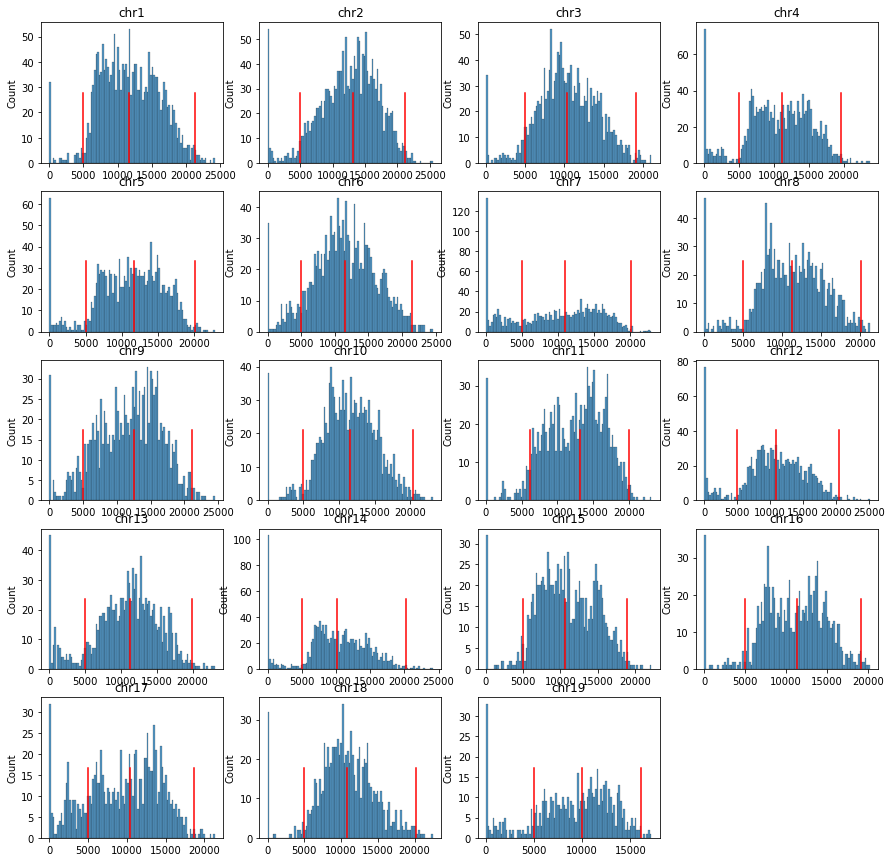

In [8]:
### fit PC using bulk raw matrices, then perform transformation 
Qall = []
binall = []

cool = cooler.Cooler(f'../04.matrices/LC462_LC716_mm10.mcool::resolutions/100000')
fig, axes = plt.subplots(5, 4, figsize=(15, 15))
for i,c in enumerate(chrom_sizes.index):
    Q = cool.matrix(balance=False, sparse=True).fetch(c).toarray()
    Q = Q - np.diag(np.diag(Q))
    
    ### covergae filtering
    rowsum = Q.sum(axis=0)
    thres = [np.percentile(rowsum[rowsum>0], 50), np.percentile(rowsum[rowsum>0], 99)]
    thres.append(thres[0]*2-thres[1])
    if thres[-1] < 5000:
        thres[-1] = 5000
    ax = axes.flatten()[i]
    sns.histplot(rowsum, bins=100, ax=ax)
    for t in thres:
        ax.plot([t, t], [0, ax.get_ylim()[1]*0.5], c='r')
    ax.set_title(c)
    binfilter = (rowsum>thres[-1])
    binall.append(binfilter)
    Q = Q[binfilter][:, binfilter]
    Qall.append(Q)
    print(c)

for i in range(chrom_sizes.shape[0], axes.flatten().shape[0]):
    axes.flatten()[i].axis('off')
    
np.save('../04.matrices/mFC_240101_DPT_rna_annotate/mFC_binfilter.npy', binall)

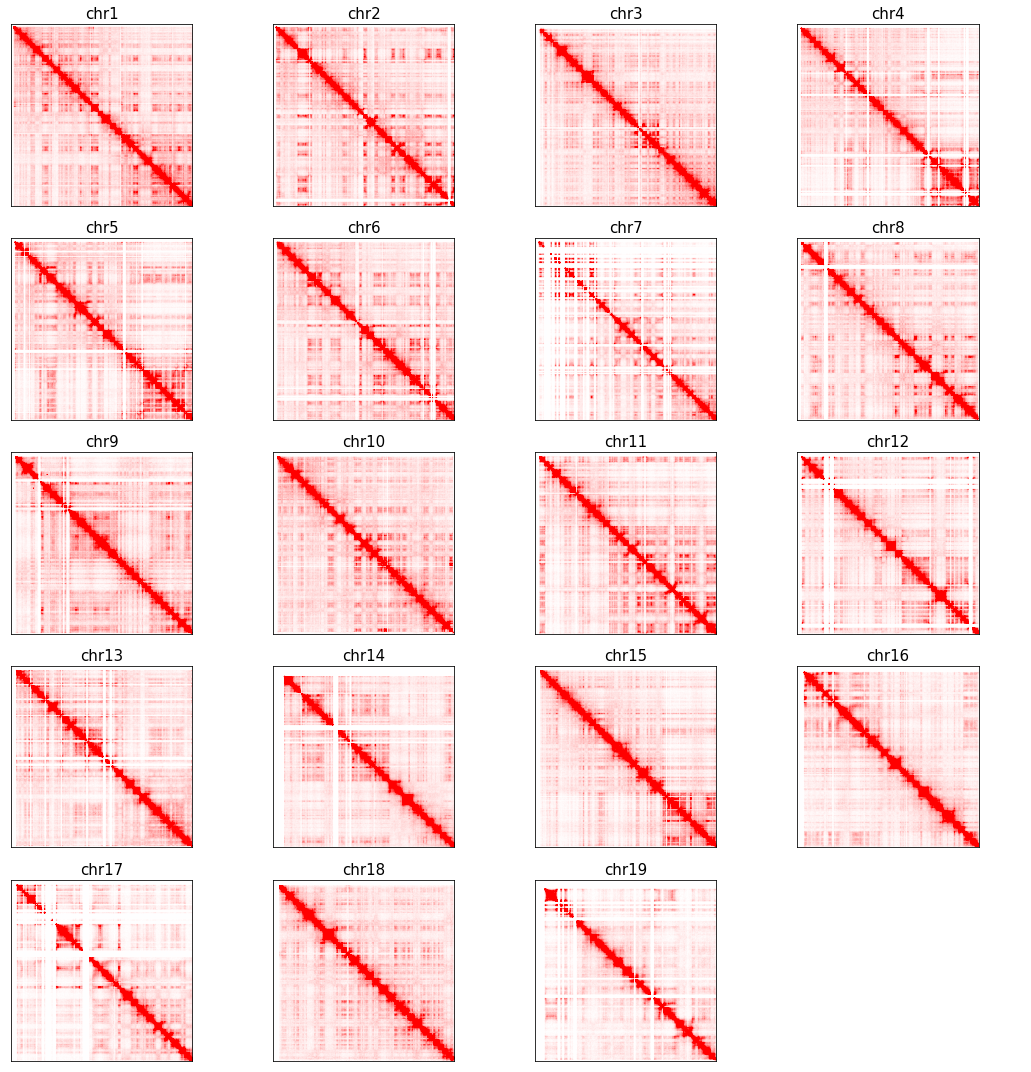

In [9]:
fig, axes = plt.subplots(5, 4, figsize=(15,15))
for i, c in enumerate(chrom_sizes.index):
    ax = axes.flatten()[i]
    n_bins = int(chrom_sizes[c] // 100000) + 1
    tmp = np.zeros((n_bins, n_bins))
    tmp[np.ix_(binall[i], binall[i])] = Qall[i]
    ax.imshow(tmp, cmap = 'bwr', vmin = -np.percentile(Qall[i], 95), vmax = np.percentile(Qall[i], 95))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(c, fontsize=15)

for i in range(chrom_sizes.shape[0], axes.flatten().shape[0]):
    axes.flatten()[i].axis('off')
    
plt.tight_layout()

## Get bulk model to calculate cell type compartment 

In [10]:
Call, pcall, modelall = compbulk(Qall, chrom_sizes, binall, cpg)

start distance normalization for chrom chr1...
start PCA...
start distance normalization for chrom chr2...
start PCA...
start distance normalization for chrom chr3...
start PCA...
start distance normalization for chrom chr4...
start PCA...
start distance normalization for chrom chr5...
start PCA...
start distance normalization for chrom chr6...
start PCA...
start distance normalization for chrom chr7...
start PCA...
start distance normalization for chrom chr8...
start PCA...
start distance normalization for chrom chr9...
start PCA...
start distance normalization for chrom chr10...
start PCA...
start distance normalization for chrom chr11...
start PCA...
start distance normalization for chrom chr12...
start PCA...
start distance normalization for chrom chr13...
start PCA...
start distance normalization for chrom chr14...
start PCA...
start distance normalization for chrom chr15...
start PCA...
start distance normalization for chrom chr16...
start PCA...
start distance normalization for 

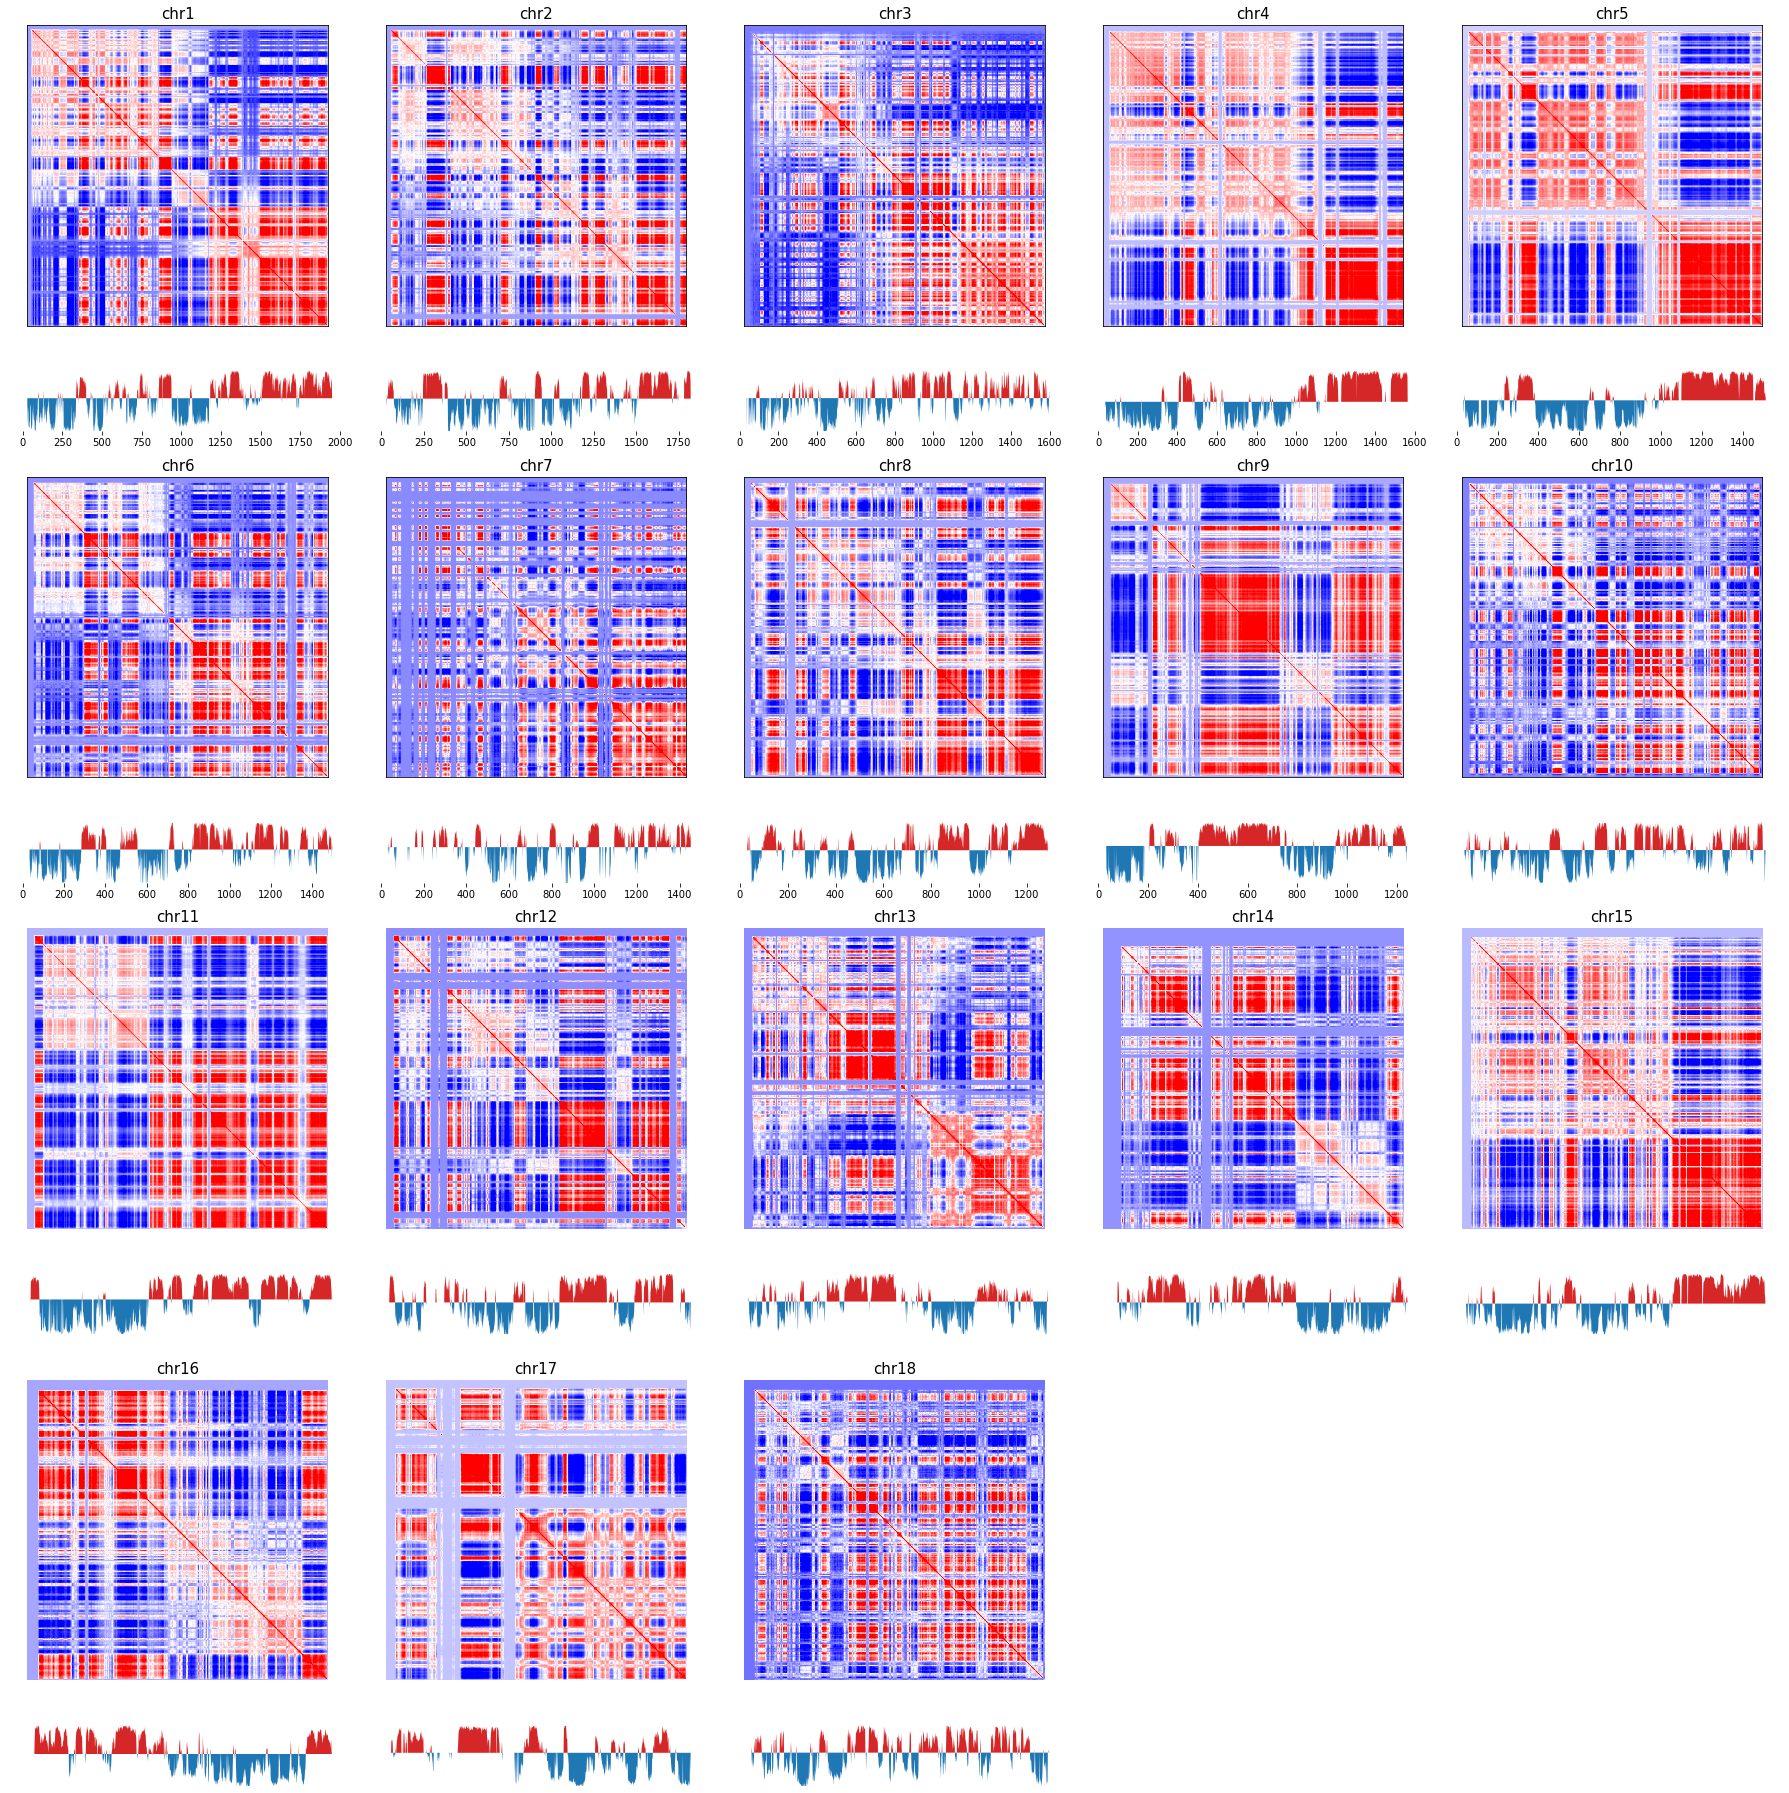

In [11]:
fig, axes = plt.subplots(8, 5, figsize=(25, 25), 
                         gridspec_kw={'height_ratios':[5,1,5,1,5,1,5,1]})
for i,c in enumerate(chrom_sizes.index[:-1]):
    nrow = 2*(i // 5)
    ncol = i % 5
    ax = axes[nrow, ncol]
    n_bins = int(chrom_sizes[c] // 100000) + 1
    tmp = np.zeros((n_bins, n_bins))
    tmp[np.ix_(binall[i], binall[i])] = Call[i]
    ax.imshow(tmp, cmap='bwr', vmin=np.percentile(Call[i], 5), vmax=np.percentile(Call[i], 95))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(c, fontsize=15)
    
    nrow = nrow + 1
    ax = axes[nrow, ncol]
    sns.despine(bottom=True, left=True, ax=ax)
    tmp = np.zeros(n_bins)
    tmp[binall[i]] = pcall[i]
    x, y = np.arange(n_bins), tmp
    ax.fill_between(x, y, 0, where=y >= 0, facecolor='C3', interpolate=True)
    ax.fill_between(x, y, 0, where=y <= 0, facecolor='C0', interpolate=True)
    ax.set_yticks([])
    ax.set_ylim([np.percentile(y, 1), np.percentile(y, 99)])

for i in range(chrom_sizes.shape[0], axes.flatten().shape[0]):
    axes.flatten()[i].axis('off')

plt.tight_layout()

## Transform cell-type matrices using bulk model

In [6]:
pca = PCA(n_components=2)

In [59]:
### cell type information are obtained in 01.mouse_cortex_cell_embedding
ipath = "/projects/ps-renlab2/y2xie/projects/77.LC/62.schiC_MouseCortex_NovaSeq_230723/hicluster/raw_matrix/merge_raw/DPT_embed/"
file_list = [file for file in os.listdir(ipath) if file.endswith('_chunk0')]
leg = [file.split('_')[0] for file in file_list]

mode = 'raw'
res = 100000

In [60]:
sad = np.zeros((len(leg), 50, 50))
count = np.zeros((len(leg), 50, 50))
comp = []

cpu = 8
with ProcessPoolExecutor(cpu) as executor:
    futures = {}
    for t,ct in enumerate(leg):
        cool = cooler.Cooler(f'{ipath}/{ct}/{ct}.mcool::resolutions/100000')
        future = executor.submit(
            compsaddle,
            cool=cool,
        )
        futures[future] = t

    for future in as_completed(futures):
        t = futures[future]
        ct = leg[t]
        xx, yy, zz = future.result()
        comp.append(pd.Series(xx, name=ct))
        sad[t] += yy
        count[t] += zz
        print(f'{ct} finished')
        
bins_df = cool.bins()[:]
bins_df.index = bins_df['chrom'].astype(str) + '-' + (bins_df['start'] // res).astype(str)
compidx = np.concatenate([bins_df.index[bins_df['chrom']==c][binall[i]] for i,c in enumerate(chrom_sizes.index[:-1])])

comp = pd.concat(comp, axis=1)
comp.index = compidx

### normalize
sad = sad / count

OGC finished
STRGA finished
OPC finished
CLAGL finished
OBGA finished
MGL finished
ITL23GL finished
ASC finished
VIPGA finished
ITL45GL finished
OBGL finished
NPGL finished
VLMC finished
ITL6GL finished
PVGA finished
PTGL finished
ITL5GL finished
SSTGA finished
D12MSN finished
CTGL finished


In [24]:
comp.to_hdf(f'../04.matrices/mFC_240101_DPT_rna_annotate/compartment/comp_merge_{mode}_pca.hdf', key='data')
np.save(f'../04.matrices/mFC_240101_DPT_rna_annotate/compartment/saddle_merge_{mode}_pca.npy', sad)

In [28]:
### Export compartment file in bed format
comp = pd.read_hdf("../04.matrices/mFC_240101_DPT_rna_annotate/compartment/comp_merge_raw_pca.hdf")
bins_df.index = bins_df['chrom'].astype(str) + '-' + bins_df['start'].astype(str) + '-' + bins_df['end'].astype(str)
compidx = np.concatenate([bins_df.index[bins_df['chrom']==c][binall[i]] for i,c in enumerate(chrom_sizes.index[:-1])])
comp.index = compidx

for f in comp.columns:
    bedgraph_file = '../04.matrices/mFC_240101_DPT_rna_annotate/compartment/' + f + '_raw_comp.bedGraph'
    with open(bedgraph_file, 'w') as file:
        file.write('track type=bedGraph\n')
        for index, value in comp[f].iteritems():
            chrom, start, end = index.split('-')
            file.write(f'{chrom}\t{start}\t{end}\t{value}\n')

## Differential compartments with dchic

In [84]:
outdir = '../04.matrices/mFC_240101_DPT_rna_annotate/compartment/dchic/'

res = 100_000
binall = pd.DataFrame(index=comp.index)
binall['chrom'] = binall.index.str.split('-').str[0]
binall['start'] = binall.index.str.split('-').str[1].astype(int) * res
binall['end'] = binall['start'] + res

for xx in leg:
    os.makedirs(f'{outdir}/{xx}_100Kb_pca/intra_pca/{xx}_100Kb_mat/', exist_ok=True)
    tmp = binall.copy()
    tmp['pc'] = comp[xx]
    for c in chrom_sizes.index[:-1]:
        tmp.loc[tmp['chrom']==c].to_csv(f'{outdir}/{xx}_100Kb_pca/intra_pca/{xx}_100Kb_mat/{c}.pc.bedGraph', sep='\t', header=False, index=False)

In [85]:
tmp = pd.DataFrame(index=leg)
tmp['matrix_path'] = '.'
tmp['bed_path'] = '.'
tmp['sample'] = tmp.index + '_100Kb'
tmp['group'] = tmp.index
tmp.to_csv(f'{outdir}/input.txt', sep='\t', header=False, index=False)

In [ ]:
### Run dchic for differential compartment analysis:
### Rscript /projects/ps-renlab2/y2xie/packages/dcHiC/dchicf.r --file input.txt --pcatype analyze --dirovwt T --diffdir .

## Plot examples (Fig.1F)

In [51]:
leg_select = ['VIPGA', 'PVGA', 'PTGL', 'ITL6GL', 'OGC', 'OPC']
meta = pd.read_hdf('droplethic_DPT_RNA_AllCooL_cluster.hdf', slot = 'data')
np.unique(meta[meta['rnatype'].isin(leg_select)]['rnatype'], return_counts = True)

(array(['ITL6GL', 'OGC', 'OPC', 'PTGL', 'PVGA', 'VIPGA'], dtype=object),
 array([268, 382, 356, 199, 209, 234]))

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 19 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'G', 'I', 'L', 'O', 'P', 'T', 'V', 'five', 'minus', 'nonmarkingreturn', 'period', 'six', 'space', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 17, 19, 21, 24, 25, 36, 38, 42, 44, 47, 50, 51, 55, 57, 3228]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 19 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'G', 'I', 'L', 'O', 'P', 'T', 'V', 'five', 'minus', 'nonmarkingreturn', 'period', 'six', 'space', 

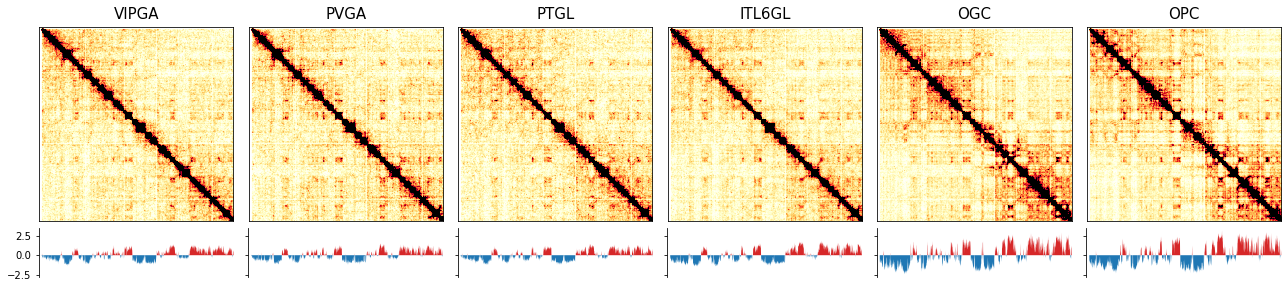

In [75]:
### plot impute matrix and raw compartment
ipath = "/projects/ps-renlab2/y2xie/projects/77.LC/62.schiC_MouseCortex_NovaSeq_230723/hicluster/imputed_matrix/100kb_resolution/mcool/DPT/"
comp = pd.read_hdf("../04.matrices/mFC_240101_DPT_rna_annotate/compartment/comp_merge_raw_pca.hdf")
binall = np.load('../04.matrices/mFC_240101_DPT_rna_annotate/mFC_binfilter.npy', allow_pickle=True)

chrom = 'chr1'
binfilter = binall[0]
res = 100_000
ll, rr = 400, 800
n_bins = (int(chrom_sizes.loc[chrom]) // res + 1)

fig, axes = plt.subplots(2, 6, figsize=(18, 4), gridspec_kw={'height_ratios':[2, 0.5]}, sharex='col', sharey='row')

for k, ct in enumerate(leg_select):
    cool = cooler.Cooler(f'{ipath}/{ct}/{ct}.Q.cool::/')
    Q = cool.matrix(balance=False, sparse=True).fetch(chrom).toarray()
    Q = Q - np.diag(np.diag(Q))
    
    ax = axes[0, k]
    tmp = np.zeros((n_bins, n_bins))
    tmp[np.ix_(binfilter, binfilter)] = Q[binfilter][:, binfilter]

    im = ax.imshow(tmp, cmap = 'fall', vmin = 0, vmax = 0.00075)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(ct, fontsize = 15, y = 1.01)
    
    ax = axes[1, k]
    sns.despine(bottom=True, ax=ax)
    tmp = np.zeros(n_bins)
    tmp[binfilter] = comp.loc[(comp.index.str.split('-').str[0] == chrom), ct]

    ax.fill_between(np.arange(len(tmp)), tmp, 0, where = tmp >= 0, facecolor='C3', interpolate=True)
    ax.fill_between(np.arange(len(tmp)), tmp, 0, where = tmp <= 0, facecolor='C0', interpolate=True)

plt.tight_layout()

plt.savefig(f'plot/mFC_240101_DPT_rna_annotation_example_imputemap_rawcomp_{chrom}.pdf', transparent = True)

## Variable domains analysis

In [5]:
### single cell domain is pre-calculated using schic_domain_v2.sh
import anndata
ipath = '/projects/ps-renlab2/y2xie/projects/77.LC/62.schiC_MouseCortex_NovaSeq_230723/hicluster/imputed_matrix/25kb_resolution/domain/DPT/'
tad_path_list = glob.glob(f'{ipath}/*/*.boundary.h5ad')

sc_border = []
for xx in tad_path_list:
    sc_border.append(anndata.read_h5ad(xx))
    
sc_border = anndata.AnnData.concatenate(*sc_border, index_unique=None)
sc_border

/home/y2xie/anaconda3/envs/seurat/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


AnnData object with n_obs × n_vars = 6215 × 109032
    obs: 'batch'
    var: 'chrom', 'start', 'end'

In [6]:
sc_border.X = sc_border.X.astype(int)
sc_border = sc_border[sc_border.obs.index.isin(meta.index)].copy()
sc_border = sc_border[:, ~sc_border.var['chrom'].isin(['chrX','chrY','chrM','chrL'])].copy()
sc_border.obs = meta.loc[sc_border.obs.index]
sc_border.raw = sc_border.copy()

sc_border.write_h5ad(f'{ipath}/mFC_240101_DPT_rna_annotation_cell_{sc_border.shape[0]}_boundary.h5ad')

... storing 'bc' as categorical
... storing 'sample' as categorical
... storing 'anno' as categorical
... storing 'rnatype' as categorical


In [7]:
res = 25_000
bound_count_ct = []
for xx in np.unique(meta['rnatype']):
    bound_count_ct.append(sc_border.raw.X[sc_border.obs['rnatype']==xx].getnnz(axis=0))

bound_count_ct = pd.DataFrame(bound_count_ct, index=np.unique(meta['rnatype']), 
                              columns=sc_border.raw.var['chrom'].astype(str) + '_' + (sc_border.raw.var['start'] // res).astype(str))
cell_count_ct = sc_border.obs['rnatype'].value_counts().loc[np.unique(meta['rnatype'])]

bound_count_ct.to_hdf(f'{ipath}/mFC_240101_DPT_rna_annotation_boundcount.hdf', key='data')
cell_count_ct.to_csv(f'{ipath}/mFC_240101_DPT_rna_annotation_cellcount.csv.gz')

In [8]:
bound_prob_ct = (bound_count_ct / cell_count_ct[:,None]).T

/scratch/y2xie/34092168.tscc-mgr7.local/ipykernel_14989/2332813449.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  bound_prob_ct = (bound_count_ct / cell_count_ct[:,None]).T


In [9]:
import xarray
ins_list = glob.glob(f'{ipath}/*/*.insulation.nc')

sc_ins = []
ins_name = []
for xx in ins_list:
    ins_name.append(xx.split('/')[-2])
    ins_count = xarray.open_dataset(xx)
    sc_ins.append(ins_count['__xarray_dataarray_variable__'].to_pandas().mean())

sc_ins = pd.concat(sc_ins, axis=1)
bin_name = ins_count['bin_chrom'].to_pandas() + '-' + ins_count['bin_start'].to_pandas().astype(str) + '-' + ins_count['bin_end'].to_pandas().astype(str)
sc_ins.index = bin_name
sc_ins.columns = ins_name

sc_ins.to_csv(f"{ipath}/mFC_240101_DPT_rna_annotation_insulation.csv")

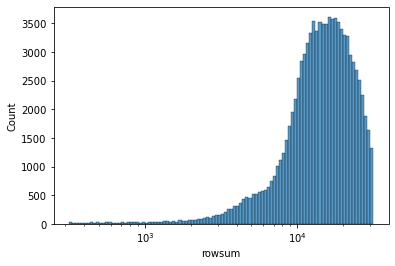

In [34]:
### generate domain blacklist
chrom_sizes = pd.read_csv("/projects/ps-renlab2/y2xie/projects/genome_ref/mm10.noXY.chrom.sizes", sep='\t', header=None, index_col=0)
cool = cooler.Cooler('../04.matrices/LC462_LC716_mm10.mcool::/resolutions/25000')

data = cool.pixels()[:]
data = sp.sparse.csr_matrix((data['count'], (data['bin1_id'], data['bin2_id'])), shape=cool.shape)

bin_df = cool.bins()[:]
bin_df['rowsum'] = data.sum(axis=0).A1

sns.histplot(bin_df.loc[bin_df['rowsum']>0, 'rowsum'], bins=100, log_scale=10, binrange=(2.5,4.5))
bin_df.loc[bin_df['rowsum']<3e3, ['chrom', 'start', 'end']].to_csv('../hicluster/mm10.main.rowsum3000.25kb.bed', sep='\t', header=False, index=False)

In [35]:
bkl = pd.read_csv(f'../hicluster/mm10.main.rowsum3000.25kb.bed', sep='\t', header=None, index_col=None)
binall['bklfilter'] = True
for c in chrom_sizes.index:
    chrfilter = (binall['chrom']==c)
    tmp = binall.loc[chrfilter.values]
    tmp.iloc[:10, -1] = False
    tmp.iloc[-10:, -1] = False
    for xx,yy in bkl.loc[bkl[0]==c, [1,2]].values // res:
        tmp.iloc[max([0,xx-2]):(yy+2), -1] = False
    binall.loc[chrfilter] = tmp.copy()

print(binall['bklfilter'].sum())

101623


In [36]:
### filter bad bins
binall = binall.loc[binall['chrom'].isin(chrom_sizes.index)]
binall['bin'] = binall['chrom'] + "-" + binall['start'].astype(str) + "-" + binall['end'].astype(str)
print(sc_ins.shape)

sc_ins = sc_ins.loc[binall['bin']]
print(sc_ins.shape)

(109032, 20)
(98520, 20)


In [42]:
### Domains for each cluster?
ins_ct = pd.DataFrame(0, index=sc_ins.index, columns=sc_ins.columns)
for xx in ins_ct.columns:
    sel = []
    for c in chrom_sizes.index:
        idx = np.where(binall['chrom']==c)[0]
        if len(idx)>0:
            data = -sc_ins.iloc[idx, ][xx]
            peaks, _ = find_peaks(data, distance=5)
            sel.append(idx.min() + peaks)
    sel = np.concatenate(sel)
    ins_ct.loc[ins_ct.index[sel], xx] = 1

ins_ct.to_csv('mFC_240101_DPT_rna_annotation_hicluster_25kb_insulation_ct_lm_hicluster_v2.csv')

## Cell type specific domains: chi-square test

In [43]:
from statsmodels.sandbox.stats.multicomp import multipletests as FDR
from scipy.stats import chi2_contingency
import xarray
from scipy.signal import find_peaks
from scipy.stats import norm

def residuals(observed, expected):
    return (observed - expected) / np.sqrt(expected)

def diff_bound(bound_count_ct, cell_count_ct):
    tmp = cell_count_ct[:,None] - bound_count_ct
    resd = [0 for _ in range(bound_count_ct.shape[1])]
    stats = np.zeros(bound_count_ct.shape[1])
    pv = np.ones(bound_count_ct.shape[1])
    binfilter = np.logical_and(bound_count_ct.sum(axis=0)>0, tmp.sum(axis=0)>0)
    for i in range(bound_count_ct.shape[1]):
        if binfilter[i]:
            contig = [bound_count_ct.values[:,i], tmp.values[:,i]]
            stats[i], pv[i], dof, expected = chi2_contingency(contig)
            resd[i] = residuals(contig, expected)
    fdr = FDR(pv, 0.01, 'fdr_bh')[1]
    return stats, pv, resd

def shuffle_ct(i):
    global cell_count_ct, sc_border, leg
    np.random.seed(i)
    label = np.random.permutation(sc_border.obs[f'{ct_key}'])
    bound_count_ct = np.array([sc_border.X[label==xx].getnnz(axis=0) for xx in leg])
    bound_prob_ct = bound_count_ct / cell_count_ct[:,None]
    return diff_bound(bound_count_ct, cell_count_ct)[0]

def diff_bound_bulk(ins_count):
    stats = np.zeros(ins_count.shape[2])
    pv = np.ones(ins_count.shape[2])
    binfilter = (ins_count.min(axis=(0,1))>0)
    for i in range(ins_count.shape[2]):
        if binfilter[i]:
            stats[i], pv[i], _, _ = chi2_contingency(ins_count[:,:,i])
    fdr = FDR(pv, 0.01, 'fdr_bh')[1]
    return stats, pv

In [44]:
chi2sc, fdr_sc, residual = diff_bound(bound_count_ct, cell_count_ct)
ave = np.mean(chi2sc[chi2sc>0])
stdev = np.std(chi2sc[chi2sc>0])
binall['chi2filter'] = ((chi2sc - ave) / stdev)>norm.isf(0.05) ### zscore
binall['ins_lm'] = 0
for xx in sc_ins.columns:
    sel = []
    for c in chrom_sizes.index:
        idx = np.where(binall['chrom']==c)[0]
        if len(idx)>0:
            data = -sc_ins.iloc[idx, ][xx]
            peaks, _ = find_peaks(data, distance=5)
            sel.append(idx.min() + peaks)
    sel = np.concatenate(sel)
    binall.loc[binall.index[sel], 'ins_lm'] = 1

binall['probdiff'] = (bound_prob_ct.max(axis=1) - bound_prob_ct.min(axis=1)).values
binall['chi2_sc'] = chi2sc.copy()
# binall['insfc'] = (ins.max(axis=0)+0.01 / ins.min(axis=0)+0.01).values

sel = []
thres = np.min(chi2sc[fdr_sc<1e-3])
for c in chrom_sizes.index:
    idx = np.where(binall['chrom']==c)[0]
    if len(idx)>0:
        data = chi2sc[idx]
        peaks, _ = find_peaks(data, height=thres, distance=5)
        sel.append(idx.min() + peaks)
        
sel = np.concatenate(sel)

/scratch/y2xie/34092168.tscc-mgr7.local/ipykernel_14989/1050668339.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  tmp = cell_count_ct[:,None] - bound_count_ct


In [45]:
binall['diff_sc'] = 0
binall.loc[binall.index[sel], 'diff_sc'] = 1
binall.loc[:, binall.dtypes=='category'] = binall.loc[:, binall.dtypes=='category'].astype(str)

In [46]:
residual_filt = [x for x, keep in zip(residual, binall['chi2filter']) if keep]

ct_asso = []
for arr in residual_filt:
    ct_asso.append(cell_count_ct.index[arr[0] > 1.96].values)

binall[[cell_count_ct.index]] = 0
for i in range(binall.loc[binall['chi2filter']].shape[0]):
    idx = binall.loc[binall['chi2filter']].index[i]
    for xx in ct_asso[i]:
        binall.loc[idx, xx] = 1 

In [47]:
selb = (binall['chi2filter'] 
       & binall['diff_sc'] 
       & binall['bklfilter'] 
       & binall['ins_lm'] 
       & (binall['probdiff']>0.05) 
      )
print(sum(selb))

2041


<AxesSubplot:xlabel='probdiff', ylabel='Count'>

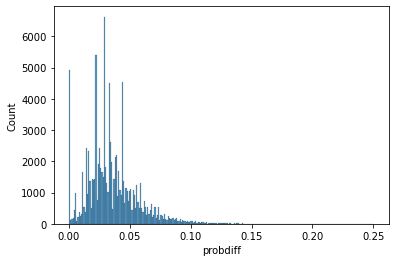

In [49]:
sns.histplot(binall['probdiff'])

In [50]:
binall.to_csv('mFC_240101_DPT_rna_annotation_hicluster_25kb_differential_boundary_bins_hicluster_v2.csv')
bound_prob_ct.to_csv("mFC_240101_DPT_rna_annotation_hicluster_25kb_boundary_probs_filt_hicluster_v2.csv")
sc_ins.to_csv('mFC_240101_DPT_rna_annotation_hicluster_25kb_insulation_hicluster_v2.csv')

## Plot examples (Fig.1G)

In [59]:
i = 1
chrom = f'chr{i}' 
mode = 'pad2_std1.0_rp0.5_sqrtvc'
binfilter = binpass[i-1]
res = 25_000
l, r = 55_200_000, 59_500_000

ll = l//res
rr = r//res

npz = sp.sparse.load_npz(f'../hicluster/imputed_matrix/25kb_resolution/domain/{mode}_{chrom}.w10.boundary.npz')
npz1 = sp.sparse.load_npz(f'../../39.Paired_HiC_NovaSeq_230125/hicluster/imputed_matrix/25kb_resolution/domain/pad2_std1_rp0.5_sqrtvc_{chrom}.w10.boundary.npz')
npz = sp.sparse.vstack([npz1, npz])

cell_id = pd.read_csv(f'../hicluster/imputed_matrix/25kb_resolution/filelist/domain_file/domainlist_{mode}_{chrom}.txt', sep = '\t', names = ['file'])
cell_id['cell'] = cell_id['file'].str.split('/').str[1].str.split('_').str[0]

cell_id1 = pd.read_csv(f'../../39.Paired_HiC_NovaSeq_230125/hicluster/imputed_matrix/25kb_resolution/filelist/domainlist_pad2_std1_rp0.5_sqrtvc_{chrom}.txt', sep = '\t', names = ['file'])
cell_id1['cell'] = "LC462:" + cell_id1['file'].str.split('/').str[1].str.split('_').str[3]

cell_id = pd.concat([cell_id1, cell_id])

tmeta = pd.merge(cell_id, meta, how = 'left', right_index = True, left_on = 'cell')

### get mean boundary probability within group
### plot only selected groups
t2 = np.array([npz[tmeta.loc[tmeta['rnatype'] == ct, 'cell'].index].sum(axis=0).A.ravel() / len(tmeta.loc[tmeta['rnatype'] == ct, 'cell'].index) for ct in korder])
prob = t2

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 18 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'G', 'I', 'L', 'O', 'P', 'T', 'V', 'five', 'nonmarkingreturn', 'one', 'period', 'six', 'space', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 24, 25, 36, 38, 42, 44, 47, 50, 51, 55, 57]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 18 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'G', 'I', 'L', 'O', 'P', 'T', 'V', 'five', 'nonmarkingreturn', 'one', 'period', 'six', 'space', 'zero']
INFO:font

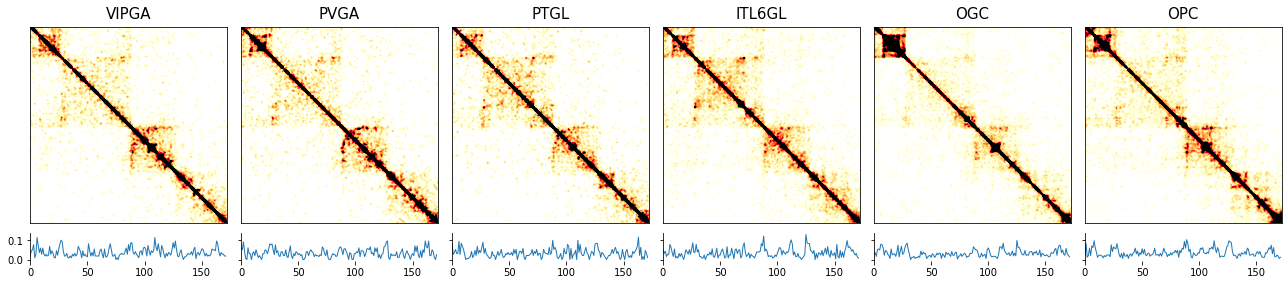

In [68]:
### 10kb
res2 = 10_000
ll2 = l//res2
rr2 = r//res2

ipath = '../hicluster/imputed_matrix/10kb_resolution/mcool/DPT/'
fig, axes = plt.subplots(2, len(korder), figsize=(3*len(korder),4), gridspec_kw={'height_ratios':[4,0.5]}, sharey='row') ### , sharex='col'

for ind, ct in enumerate(korder):
    cool = cooler.Cooler(f'{ipath}/{ct}/{ct}.Q.cool::/')
    Q = cool.matrix(balance=False, sparse=True).fetch(chrom).toarray()
    Q = Q - np.diag(np.diag(Q))
    
    ax = axes[0,ind]
    vv = 0.005
    im = ax.imshow(Q[ll2:rr2,ll2:rr2], cmap = 'fall', vmax = vv) ### 10kb
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(ct, fontsize = 15, y = 1.01)
    
    ax = axes[1, ind]
    sns.despine(bottom=True, ax=ax)

    ax.plot(np.arange(rr - ll), prob[ind, ll:rr], linewidth=1)
    ax.set_xlim([0, rr - ll]) ### 10kb

    plt.subplots_adjust(hspace=0.2)

plt.tight_layout()
plt.savefig(f'plot/mFC_240101_DPT_rna_annotation_example_imputemap_DomainProb_bulk_impute_10kb_{chrom}_{ll2}_{rr2}.pdf', transparent = True)

## Plot single cell insulation score (Fig.2C)

In [3]:
### single cell contacts stat calculated during pre-processing
meta = pd.read_csv('metadata/mFC_fast_higashi_embed64_leiden08_filt_cislong.sc.stat.csv', sep = '\t', header = 0, index_col=0)
print(meta.shape)
meta.head()

(6413, 15)


bc   total  mapped  unmapped  duplicate  \
cool_cell                                                                       
LC462:AAACGAAAGACCGCAA  AAACGAAAGACCGCAA  228171  228171         0          0   
LC462:AAACGAAAGCTTTCCC  AAACGAAAGCTTTCCC  184221  184221         0          0   
LC462:AAACGAAAGTACAACA  AAACGAAAGTACAACA  178569  178569         0          0   
LC462:AAACGAAAGTGTGTAA  AAACGAAAGTGTGTAA  406555  406555         0          0   
LC462:AAACGAACATCCTCGT  AAACGAACATCCTCGT  293100  293100         0          0   

                           cis  cis_1kb.  cis_1kb..1  cis_10kb.  trans sample  \
cool_cell                                                                       
LC462:AAACGAAAGACCGCAA  217314    182844       34468      27820  10857  LC462   
LC462:AAACGAAAGCTTTCCC  175153    149287       25865      19967   9068  LC462   
LC462:AAACGAAAGTACAACA  168299    144264       24033      18961  10270  LC462   
LC462:AAACGAAAGTGTGTAA  388887    330165       58722      46593  17668  LC462   
LC462:AAACGAACATCCTCGT  277282    240854       36428      28923  15818  LC462   

                        leiden_08      UMAP1     UMAP2    anno  
cool_cell                                                       
LC462:AAACGAAAGACCGCAA          0  18.175161  2.901577  IT23GL  
LC462:AAACGAAAGCTTTCCC          1  15.923233  2.554297  IT56GL  
LC462:AAACGAAAGTACAACA          1  15.567695  5.193507  IT56GL  
LC462:AAACGAAAGTGTGTAA          0  17.224365  3.800281  IT23GL  
LC462:AAACGAACATCCTCGT          1  13.780387  5.093247  IT56GL

In [4]:
### cell type information are obtained in 01.mouse_cortex_cell_embedding
cluster = pd.read_csv('match_droplethic_DPT_RNA_AllCooL_integration_hi_annotation.csv', header = 0, index_col=0)
meta = meta.merge(cluster, left_index=True, right_index=True)

meta.to_csv('metadata/mFC_fast_higashi_embed64_droplethic_DPT_RNA_AllCooL_integration.sc.stat.csv')

meta.head()

bc   total  mapped  unmapped  duplicate  \
LC462:AAACGAAAGACCGCAA  AAACGAAAGACCGCAA  228171  228171         0          0   
LC462:AAACGAAAGCTTTCCC  AAACGAAAGCTTTCCC  184221  184221         0          0   
LC462:AAACGAAAGTACAACA  AAACGAAAGTACAACA  178569  178569         0          0   
LC462:AAACGAAAGTGTGTAA  AAACGAAAGTGTGTAA  406555  406555         0          0   
LC462:AAACGAACATCCTCGT  AAACGAACATCCTCGT  293100  293100         0          0   

                           cis  cis_1kb.  cis_1kb..1  cis_10kb.  trans sample  \
LC462:AAACGAAAGACCGCAA  217314    182844       34468      27820  10857  LC462   
LC462:AAACGAAAGCTTTCCC  175153    149287       25865      19967   9068  LC462   
LC462:AAACGAAAGTACAACA  168299    144264       24033      18961  10270  LC462   
LC462:AAACGAAAGTGTGTAA  388887    330165       58722      46593  17668  LC462   
LC462:AAACGAACATCCTCGT  277282    240854       36428      28923  15818  LC462   

                        leiden_08      UMAP1     UMAP2    anno  rnatype  \
LC462:AAACGAAAGACCGCAA          0  18.175161  2.901577  IT23GL   ITL6GL   
LC462:AAACGAAAGCTTTCCC          1  15.923233  2.554297  IT56GL     PTGL   
LC462:AAACGAAAGTACAACA          1  15.567695  5.193507  IT56GL  ITL45GL   
LC462:AAACGAAAGTGTGTAA          0  17.224365  3.800281  IT23GL  ITL23GL   
LC462:AAACGAACATCCTCGT          1  13.780387  5.093247  IT56GL     NPGL   

                           score  hictype  
LC462:AAACGAAAGACCGCAA  0.975725      0.0  
LC462:AAACGAAAGCTTTCCC  0.975344      0.0  
LC462:AAACGAAAGTACAACA  0.999989      2.0  
LC462:AAACGAAAGTGTGTAA  0.999996      0.0  
LC462:AAACGAACATCCTCGT  0.955770      1.0

In [55]:
### Pdgfra
ipath = '../hicluster/imputed_matrix/10kb_resolution/mcool/DPT/'
i = 5
chrom = f'chr{i}'
mode = 'pad2_std1.0_rp0.5_sqrtvc'
res = 25_000
res2 = 10_000
l, r = 73_000_000, 78_000_000
region = (chrom, l, r)

ll = l//res
rr = r//res
ll2 = l//res2
rr2 = r//res2

clr = cooler.Cooler(f"../04.matrices/LC462_LC716_mm10.mcool::resolutions/{res}")
Q = clr.matrix(balance = True, sparse = True).fetch(chrom).toarray()
Q = Q - np.diag(np.diag(Q))
tmp = Q[ll:rr,ll:rr]
dstall = nd.rotate(tmp, 45, order=0, reshape=True, prefilter=False, cval=0)

### 50 cells per cluster for demo
ins = np.load(f'../hicluster/imputed_matrix/25kb_resolution/domain/pad2_std1.0_rp0.5_sqrtvc_chr{i}.w10.insulation.npy')
ins1 = np.load(f'../../39.Paired_HiC_NovaSeq_230125/hicluster/imputed_matrix/25kb_resolution/domain/pad2_std1_rp0.5_sqrtvc_chr{i}.w10.insulation.npy')
ins = np.concatenate([ins, ins1])
ins_name = np.load('../hicluster/imputed_matrix/25kb_resolution/domain/pad2_std1.0_rp0.5_sqrtvc.w10.insulation.cell_id.npy',
                  allow_pickle = True)

def subsample_group(group):
    return group.nlargest(100, 'total')### sample(n=200, replace=False)

### selectly plot
korder = ['VIPGA', 'PVGA', 'PTGL', 'ITL6GL', 'OGC', 'OPC']

submeta = meta.loc[meta['rnatype'].isin(korder)]
### arrange levels
submeta['rnatype'] = pd.Categorical(submeta['rnatype'], categories=corder, ordered=True)
submeta = submeta.groupby('rnatype', group_keys=False).apply(subsample_group)

### match order
array_indices = {value: idx for idx, value in enumerate(ins_name)}
indices = [array_indices.get(value, None) for value in submeta.index]
filt_indices = [value for value in indices if value is not None]
scins = ins[np.array(filt_indices), ll:rr]

# filt_indices
# scins.shape
tmp_df = pd.DataFrame(scins, index=ins_name[filt_indices], columns=range(l, r, 25000))
tmp_df.to_csv(f'plot/mFC_240101_DPT_rna_annotation_bulk_raw_{chrom}_{l}_{r}_ins.csv')

/scratch/y2xie/34092168.tscc-mgr7.local/ipykernel_14989/144984726.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submeta['rnatype'] = pd.Categorical(submeta['rnatype'], categories=corder, ordered=True)


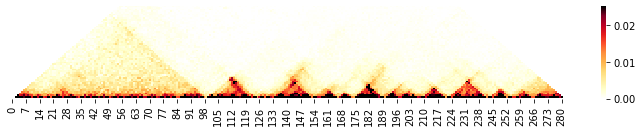

In [10]:
fig, ax = plt.subplots(figsize=(10, 2))
sns.heatmap(dstall, cmap='fall', vmax=5/tmp.shape[0], ### ,vmin=-8/tmp.shape[0]
            yticklabels = False)
ax.set_ylim([0.5*len(dstall), 0.31*len(dstall)])

plt.tight_layout()

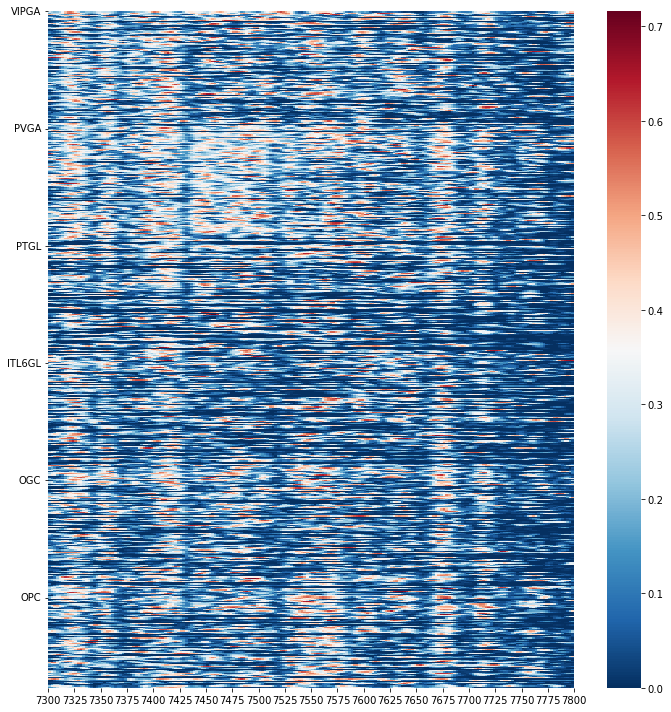

In [56]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(scins, cmap = 'RdBu_r', ax = ax)
ax.set_yticks(range(0, scins.shape[0], 100))
ax.set_yticklabels(korder)
ax.set_xticks(range(0, rr - ll + 1, 10))
ax.set_xticklabels(range(ll2, rr2 + 1, 25), rotation = 0)

plt.tight_layout()

### Plot in R using pheatmap

## Plot example (Fig.1H)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'G', 'I', 'L', 'O', 'P', 'T', 'V', 'nonmarkingreturn', 'six', 'space']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 25, 36, 38, 42, 44, 47, 50, 51, 55, 57]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'G', 'I', 'L', 'O', 'P', 'T', 'V', 'nonmarkingreturn', 'six', 'space']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 25, 36, 38, 42, 44, 47, 50, 51, 55, 57]
INF

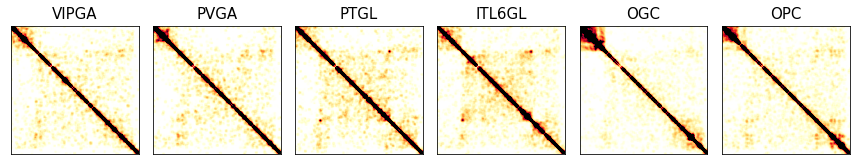

In [7]:
ipath = "/projects/ps-renlab2/y2xie/projects/77.LC/62.schiC_MouseCortex_NovaSeq_230723/hicluster/imputed_matrix/10kb_resolution/mcool/DPT/"
binall = np.load('../04.matrices/mFC_240101_DPT_rna_annotate/mFC_binfilter.npy', allow_pickle=True)

chrom = 'chr1'
binfilter = binall[0]
res = 10_000
l, r = 55_500_000, 57_500_000
ll = l//res
rr = r//res

n_bins = (int(chrom_sizes.loc[chrom]) // res + 1)
leg_select = ['VIPGA', 'PVGA', 'PTGL', 'ITL6GL', 'OGC', 'OPC']

fig, axes = plt.subplots(1, 6, figsize=(18, 4))

for k, ct in enumerate(leg_select):
    cool = cooler.Cooler(f'{ipath}/{ct}/{ct}.Q.cool::/')
    Q = cool.matrix(balance=False, sparse=True).fetch(chrom).toarray()
    Q = Q - np.diag(np.diag(Q))
    
    ax = axes[k]
    tmp = np.zeros((n_bins, n_bins))
    tmp[np.ix_(binfilter, binfilter)] = Q[binfilter][:, binfilter]
    im = ax.imshow(tmp, cmap = 'fall', vmin = 0, vmax = 0.00075)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(ct, fontsize = 15, y = 1.01)
    
plt.tight_layout()
plt.savefig(f'plot/mFC_240101_DPT_rna_annotation_example_imputemap_rawcomp_{chrom}.pdf', transparent = True)